In [5]:
import tensorflow as tf
tf.test.gpu_device_name()
import os
import numpy as np
from math import sqrt
from numpy import concatenate
import datetime as dt
import matplotlib.pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import pandas as pd
import random as rd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Conv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.optimizers import Adagrad
from tensorflow.python.keras.optimizers import Adadelta
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.initializers import RandomUniform

from google.colab import files
uploaded = files.upload()

### methods

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i))
        if i == 0:
            names += [('var1(t)')]
        else:
            names += [('var1(t+%d)' % (i))]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

  
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Saving data_dummies_index to data_dummies_index (1)


In [12]:
# Observing script runtime
startScript = dt.datetime.now()  # observe script running time

optimising = 0  # default model vs. hyper-parameter optimising
runs = 1
result = pd.DataFrame(index=range(runs), columns= ['rmse_all','rmse_val','rmse_fit','train_days', 'batch_size','train_algo','lr', 'decay','patience', 'val_split', 'activation',
                                                   'duration','scaling','regularisation', 'dropout', 'epochs'])

for i in range(0,runs,1):
  print('run: ' +str(i+1))
  
  data = pd.read_csv('data_dummies_index', header=0, index_col=0, date_parser=pd.to_datetime)
  data['temp']= data['temp'].shift(-72)    # shift temperature 72h in past to obtain 3 day ahead temperature forecast (temp from 2014-01-04 00:00:00 is switched to 2014-01-01 00:00:00
  data.rename(columns={'temp':'temp_72'}, inplace=True)
  data['hour']= data['hour'] + 1
  
  # Observing runtime of single net
  startNet = dt.datetime.now()  # observe script running time
  
  if (optimising == 0):
    scaling = 2   # 0 = No scaling | 1 = MinMax Scaling | 2 = Z-Score 
    preparation = 1
    train_days = 5
    train_algo = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.01)
    val_split = 0.25
    activation = 'tanh'
    patience = 20
    batch_size = 200
    decay = 0   # new learning rate = old learning rate / (1 + decay * iterations)) with iterations are the number of individual algo stepts not epochs
    regularisation = 0
    dropout = 0
    
  if (optimising == 1):
    
    # Hyper-parameter optimising:   
    lr_sgd_rms = 0.001 # rd.choice([0.0001, 0.001, 0.01, 0.1]) # default = 0.001
    lr_adagrad = rd.choice([0.001, 0.01, 0.1, 1])   # default = 0.01
    lr_adam = 0.0001 # rd.choice([0.0001, 0.001, 0.01]) # default = 0.0001
    decay = 0.001 #rd.choice([0,0.0001,0.001, 0.01])   # rate of decay for the learning rate (next epoch will be started using the current learning rate divided by the decay parameter)

    # optimizers:
    sgd=SGD(lr=lr_sgd_rms, momentum=0.9, decay=decay, nesterov=False)  # default: SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    rmsprop=RMSprop(lr=lr_sgd_rms, rho=0.9, epsilon=None, decay=decay) # default:RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    adagrad=Adagrad(lr=lr_adagrad, epsilon=None, decay=decay)    # default: Adagrad(lr=0.01, epsilon=None, decay=0.0)
    adam=Adam(lr=lr_adam, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay, amsgrad=False)   # default=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    train_algo = rd.choice([rmsprop, adam])
    
    scaling = 2   # rd.choice([0, 1, 2])   # 0 = No scaling | 1 = MinMax Scaling | 2 = Z-Score 
    preparation = 1 # rd.choice([1, 2])
    val_split = 0.25 #rd.choice([0.25, 0.3, 0.35])
    train_days = rd.choice([ 5, 7])
    activation = 'tanh' # rd.choice([ 'sigmoid', 'relu', 'tanh'])
    patience = rd.choice([ 10, 20])
    batch_size = 200 # rd.choice([50, 100, 150, 200, 250, 300])
    regularisation = 0 # rd.choice([0, 0.001, 0.01, 0.1])
    dropout = 0 # rd.choice([0.1, 0.2 , 0.3])

  # 1.3 Scaling

  # Scaling the data between min and max: x_scaled = (x - min(x)) / ( max(x) - min(x)) only with parameters calculated from the train set
  if (scaling == 1):
      min, max = -1, 1
      min_load_train, max_load_train = np.max(data['load']['2014-01-01 00:00:00':'2015-12-31 23:00:00']), np.min(data['load']['2014-01-01 00:00:00':'2015-12-31 23:00:00'])
      data['load'] = ((data['load'] - min_load_train) / (max_load_train - min_load_train)) * (max - min) + min    # Inverse scaling: x = (x_scaled - min) / (max - min) * (max_load_train - min_load_train) + min_load_train
      min_temp_train, max_temp_train = np.max(data['temp_72']['2014-01-01 00:00:00':'2015-12-31 23:00:00']), np.min( data['temp_72']['2014-01-01 00:00:00':'2015-12-31 23:00:00'])
      data['temp_72'] = ((data['temp_72'] - min_temp_train) / (max_temp_train - min_temp_train)) * (max - min) + min  # Inverse scaling: x = (x_scaled - min) / (max - min) * (max_load_train - min_load_train) + min_load_train

  # Scaling the data as folllows:  x_scaled = (x - mean(x)) / st(x) only with parameters calculated from the train set
  if (scaling == 2):
      mean_load_train, sd_load_train = np.mean(data['load']['2014-01-01 00:00:00':'2015-12-31 23:00:00']), np.sqrt(np.var(data['load']['2014-01-01 00:00:00':'2015-12-31 23:00:00']))
      data['load'] = (data['load'] - mean_load_train) / sd_load_train   # Inverse scaling: x = x_scaled * sd_load_train + mean_load_train
      mean_temp_train, sd_temp_train = np.mean(data['temp_72']['2014-01-01 00:00:00':'2015-12-31 23:00:00']), np.sqrt(np.var(data['temp_72']['2014-01-01 00:00:00':'2015-12-31 23:00:00']))
      data['temp_72'] = (data['temp_72'] - mean_temp_train) / sd_temp_train  # Inverse scaling: x = x_scaled * sd_load_train + mean_load_train


  data = data[['load','temp_72']]       # chose columns to include in forecast (26304, 3) from 2014-01-01 00:00:00 until 2016-12-31 23:00:00

  # ensure all data is float
  values = data.values.astype('float32')

  # specify the number of lag hours
  train_n = 24*train_days
  predict_n = 24*1
  n_features = data.shape[1]   # number of input variables


  # split into train and test sets
  train_samples = round(365*2*24*(1-val_split))
  val_samples = 365*2*24
  train = series_to_supervised(values[:train_samples, :],train_n, predict_n).values
  val = series_to_supervised(values[train_samples:val_samples, :],train_n, predict_n).values
  test = series_to_supervised(values[val_samples:, :],train_n, predict_n).values

  # split into input and outputs
  input_cols = train_n * n_features    # columns of input tensor
  X_train, y_train = train[:, :input_cols], train[:, -predict_n:]  # (training samples, columns of input tensor) | (training samples, number of periods to predict)
  X_val, y_val = val[:, :input_cols], val[:, -predict_n:]  # (training samples, columns of input tensor) | (training samples, number of periods to predict)
  X_test, y_test = test[:, :input_cols], test[:, -predict_n:]  # (testing samples, columns of input tensor) | (testing samples samples, number of periods to predict)


  # Selecting only every j-th sample
  j = 1   # j = 24 means you only consider every 24th sample
  X_train, y_train = np.array(pd.DataFrame(X_train).iloc[::j, :]), np.array(pd.DataFrame(y_train).iloc[::j, :])
  X_test, y_test = np.array(pd.DataFrame(X_test).iloc[::j, :]), np.array(pd.DataFrame(y_test).iloc[::j, :])

  # reshape input to be 3D [samples, timesteps, features]
  X_train = X_train.reshape((X_train.shape[0], train_n, n_features))  # (training samples, number of periods to train, number of input variables)
  X_test = X_test.reshape((X_test.shape[0], train_n, n_features)) # # (testing samples, number of periods to train, number of input variables)
  X_val = X_val.reshape((X_val.shape[0], train_n, n_features))  # (training samples, number of periods to train, number of input variables)

  ##### 02 Network selection
  filters = 60
  kernels = 8

  # architecture
  mv_cnn = Sequential()

  mv_cnn.add(Conv1D(filters=filters, kernel_size=kernels, activation=activation, input_shape=(X_train.shape[1], X_train.shape[2])))
  mv_cnn.add(Dropout(dropout))
  mv_cnn.add(MaxPooling1D(pool_size=2))
  
  mv_cnn.add(Flatten())
  mv_cnn.add(Dense(100, activation='relu'))

  mv_cnn.add(Dense(units=predict_n, activation='linear', kernel_initializer=RandomUniform(minval=-0.05, maxval=0.05)))

  # compilation
  mv_cnn.compile(optimizer= train_algo, loss='mse')

  # patient early stopping
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

  # fit model
  history = mv_cnn.fit(X_train, y_train, batch_size = batch_size, epochs=500, verbose=2, validation_data=(X_val, y_val),callbacks=[es], shuffle=True) # validation_split=0.25 | , callbacks=[es]

  
  ##### 03 Evaluation

  # plot history
  plt.plot(history.history['loss'][10:], label='train')
  plt.plot(history.history['val_loss'][10:], label='test')
  plt.legend()
  plt.close()


  # prediction
  if (scaling == 0):
      yhat = mv_cnn.predict(X_test)
      yval = mv_cnn.predict(X_val)
      yfit = mv_cnn.predict(X_train)  # fitted values

  if (scaling == 1):
      yhat_s = mv_cnn.predict(X_test)
      yhat = (yhat_s - min) / (max - min) * (max_load_train - min_load_train) + min_load_train
      y_test = (y_test - min) / (max - min) * (max_load_train - min_load_train) + min_load_train
      
      yval_s = mv_cnn.predict(X_val)
      yval = (yval_s - min) / (max - min) * (max_load_train - min_load_train) + min_load_train
      y_val = (y_val - min) / (max - min) * (max_load_train - min_load_train) + min_load_train
      
      yfit_s = mv_cnn.predict(X_train)
      yfit = (yfit_s - min) / (max - min) * (max_load_train - min_load_train) + min_load_train
      y_train = (y_train - min) / (max - min) * (max_load_train - min_load_train) + min_load_train

  if (scaling == 2):
      yhat_s = mv_cnn.predict(X_test)
      yhat = yhat_s * sd_load_train + mean_load_train
      y_test = y_test * sd_load_train + mean_load_train

      yval_s = mv_cnn.predict(X_val)
      yval = yval_s * sd_load_train + mean_load_train
      y_val = y_val * sd_load_train + mean_load_train

      yfit_s = mv_cnn.predict(X_train)
      yfit = yfit_s * sd_load_train + mean_load_train
      y_train = y_train  * sd_load_train + mean_load_train

  # # # # plot prediction
  # for i in range(0, len(y_test), 24*7*4):
  #     plt.figure(i)
  #     plt.plot(yhat[i], label='prediction')
  #     plt.plot(y_test[i], label ='observation')
  #     plt.title('prediction of week ' + str((round(i/(24*7)+1,0))))
  #     plt.xlabel('hour');plt.ylabel('MW');plt.legend()
  #     plt.legend()

  # # # plot "fitted values"
  # for i in range(0, len(y_train), 24*7*4):
  #     plt.figure(i+10)
  #     plt.plot(yfit[i], label='fitted values')
  #     plt.plot(y_train[i], label ='observation')
  #     plt.title('fitted values of week ' + str(int(i+1)/(24*7)))
  #     plt.xlabel('hour');plt.ylabel('MW');plt.legend()
  #     plt.legend()

  # Specification
  print('Optimising: ' + str(optimising))
  
  # evaluation measures
  rmse_all = np.sqrt(mean_squared_error(y_test,yhat)); print('rmse_all: ' + str(rmse_all))
  rmse_val = np.sqrt(mean_squared_error(y_val,yval)); print('rmse_val: ' + str(rmse_val))
  rmse_fit = np.sqrt(mean_squared_error(y_train,yfit)); print('rmse_fit: ' + str(rmse_fit))
  time_net = dt.datetime.now() - startNet; print ('time_net: ' + str(time_net))  # observe runtime of single neural net
  mae_overall = mean_absolute_error(y_test,yhat); print('mae_overall: ' + str(mae_overall))
  mape_overall = mean_absolute_percentage_error(y_test,yhat); print('mape_overall: ' + str(mape_overall))
  
  if (optimising == 1):
    result['rmse_all'][i] = rmse_all
    result['rmse_val'][i] = rmse_val
    result['rmse_fit'][i] = rmse_fit
    result['train_days'][i] = train_days
    result['batch_size'][i] = batch_size
    if(train_algo == sgd ):
      algo = 'sgd'
    if(train_algo == rmsprop):
      algo = 'rmsprop'
    if(train_algo == adagrad):
      algo = 'adagrad'
    if(train_algo == adam):
      algo ='adam'
    result['train_algo'][i] = algo    
    if(train_algo == sgd or train_algo == rmsprop):
      lr = lr_sgd_rms
    if(train_algo == adagrad):
      lr = lr_adagrad
    if(train_algo == adam):
      lr = lr_adam
    result['lr'][i] = lr
    result['decay'][i] = decay
    result['patience'][i] = patience 
    result['val_split'][i] = val_split
    result['activation'][i] = activation   
    result['duration'][i] = time_net 
    result['scaling'][i] = scaling
    result['regularisation'][i] = regularisation 
    result['dropout'][i] = dropout
    result['epochs'][i] = es.stopped_epoch
    result

time_script = dt.datetime.now() - startScript; print ('time_script: ' + str(time_script))  # observe runtime of whole script



  ## Download model
  #mv_lstm.save('mv_lstm' + str(np.round(rmspe_overall,2)) + '.h5') 
  #from google.colab import files
  #files.download('mv_lstm' + str(np.round(rmspe_overall,2)) + '.h5')

run: 1
Train on 12997 samples, validate on 4237 samples
Epoch 1/500
12997/12997 - 1s - loss: 0.1042 - val_loss: 0.0523
Epoch 2/500
12997/12997 - 0s - loss: 0.0422 - val_loss: 0.0303
Epoch 3/500
12997/12997 - 0s - loss: 0.0337 - val_loss: 0.0246
Epoch 4/500
12997/12997 - 0s - loss: 0.0286 - val_loss: 0.0273
Epoch 5/500
12997/12997 - 0s - loss: 0.0257 - val_loss: 0.0237
Epoch 6/500
12997/12997 - 0s - loss: 0.0241 - val_loss: 0.0186
Epoch 7/500
12997/12997 - 0s - loss: 0.0230 - val_loss: 0.0172
Epoch 8/500
12997/12997 - 0s - loss: 0.0219 - val_loss: 0.0175
Epoch 9/500
12997/12997 - 0s - loss: 0.0214 - val_loss: 0.0165
Epoch 10/500
12997/12997 - 0s - loss: 0.0209 - val_loss: 0.0179
Epoch 11/500
12997/12997 - 0s - loss: 0.0205 - val_loss: 0.0165
Epoch 12/500
12997/12997 - 0s - loss: 0.0202 - val_loss: 0.0162
Epoch 13/500
12997/12997 - 0s - loss: 0.0199 - val_loss: 0.0166
Epoch 14/500
12997/12997 - 0s - loss: 0.0196 - val_loss: 0.0158
Epoch 15/500
12997/12997 - 0s - loss: 0.0194 - val_loss: 

In [0]:
# Download model
mv_cnn.save('mv_cnn_basic_final.h5') 
from google.colab import files
files.download("mv_cnn_basic_final.h5")

In [0]:
# Download y_test and y_hat
pd.DataFrame(y_test).to_csv('y_test__basic_final') 
from google.colab import files
files.download('y_test__basic_final')

pd.DataFrame(yhat).to_csv('yhat_cnn_basic_final') 
from google.colab import files
files.download('yhat_cnn_basic_final')

In [0]:
# Download result
result.to_csv('result_16') 
from google.colab import files
files.download("result_16")

In [0]:
result

,rmse_all,rmse_val,rmse_fit,train_days,batch_size,train_algo,lr,decay,patience,val_split,activation,duration,scaling,regularisation,dropout,epochs
0,11.4326,9.64087,9.44151,7,200,adam,0.0001,0,20,0.25,tanh,0:00:56.046413,2,0,0,132
1,14.3977,12.97,12.8227,5,200,rmsprop,0.001,0,10,0.25,tanh,0:00:10.495600,2,0,0,17
2,12.0322,10.0317,10.3352,5,200,rmsprop,0.001,0,10,0.25,tanh,0:00:16.300485,2,0,0,34
3,11.9879,10.3443,9.24079,7,200,rmsprop,0.001,0,20,0.25,tanh,0:00:24.643944,2,0,0,53
4,11.6386,9.7502,10.0304,7,200,adam,0.0001,0,10,0.25,tanh,0:00:34.368526,2,0,0,73
5,11.3124,9.40541,9.69915,5,200,adam,0.0001,0,10,0.25,tanh,0:00:55.036645,2,0,0,135
6,11.2015,9.31814,9.47985,5,200,adam,0.0001,0,20,0.25,tanh,0:01:05.549135,2,0,0,161
7,11.6246,9.74226,9.91975,7,200,adam,0.0001,0,10,0.25,tanh,0:00:41.107750,2,0,0,85
8,12.9138,11.1491,11.4261,5,200,rmsprop,0.001,0,10,0.25,tanh,0:00:13.506490,2,0,0,22
9,11.6738,9.99764,9.06671,7,200,rmsprop,0.001,0,20,0.25,tanh,0:00:24.791026,2,0,0,49


In [0]:
result[result['rmse_all'] == np.min(result['rmse_all'])]


,rmse_all,rmse_val,rmse_fit,train_days,batch_size,train_algo,lr,decay,patience,val_split,activation,duration,scaling,regularisation,dropout,epochs
3,11.2489,9.30832,9.14551,5,200,rmsprop,0.001,0.001,20,0.25,tanh,0:00:29.040236,2,0,0,65


In [0]:
result[result['rmse_val'] == np.min(result['rmse_val'])]

,rmse_all,rmse_val,rmse_fit,train_days,batch_size,train_algo,lr,decay,patience,val_split,activation,duration,scaling,regularisation,dropout,epochs
8,11.2784,9.25866,9.03997,5,200,rmsprop,0.001,0.001,20,0.25,tanh,0:00:32.687776,2,0,0,71


In [0]:
np.mean(result[result['scaling'] == 1]['rmse_all'])

In [0]:
# Download result
result.to_csv('result_3') 
from google.colab import files
files.download("result_3")

In [0]:
result[result['rmse_val'] == np.min(result['rmse_val'])]

,rmse_all,rmse_val,rmse_fit,train_days,batch_size,train_algo,lr,decay,patience,val_split,activation,duration,scaling,regularisation,dropout,epochs
6,11.5561,9.62515,10.4645,5,250,adam,0.0001,0,20,0.35,tanh,0:07:50.926777,2,0,0.1,156


MessageError: ignored

In [0]:
# Download result
pd.DataFrame(y_test).to_csv('y_test_basic_final') 
from google.colab import files
files.download("y_test_basic_final")

In [0]:
# # # plot prediction
for i in range(0, len(y_test), 24*7*4):
   plt.figure(i)
   plt.plot(yhat[i], label='prediction')
   plt.plot(y_test[i], label ='observation')
   plt.title('prediction of week ' + str((round(i/(24*7)+1,0))))
   plt.xlabel('hour');plt.ylabel('MW');plt.legend()
   plt.legend()

In [0]:
yhat

array([[1.8522586 , 1.7890608 , 1.8273592 , ..., 1.7097802 , 1.5824311 ,
        1.4353302 ],
       [1.7983415 , 1.815997  , 1.892814  , ..., 1.557348  , 1.4230052 ,
        1.3118296 ],
       [1.8696102 , 1.9729347 , 2.0193274 , ..., 1.3698237 , 1.2659166 ,
        1.2522838 ],
       ...,
       [0.7788411 , 0.6194438 , 0.586766  , ..., 1.0445814 , 0.99338406,
        0.88558275],
       [0.63618433, 0.4740122 , 0.45946202, ..., 1.0319217 , 0.93276376,
        0.8152359 ],
       [0.5514755 , 0.44961414, 0.51167715, ..., 0.93460745, 0.8055191 ,
        0.721764  ]], dtype=float32)

In [0]:
#### Load model
from google.colab import files
uploaded = files.upload()

Saving mv_lstm1272.h5 to mv_lstm1272.h5


In [0]:
from tensorflow.python.keras.models import load_model
mv_lstm_load = load_model('mv_lstm1272.h5')

W0801 06:20:45.853714 139631998125952 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Orthogonal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0801 06:20:45.855826 139631998125952 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
mv_lstm_load.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 120, 120)          59040     
_________________________________________________________________
dropout_4 (Dropout)          (None, 120, 120)          0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 120)               115680    
_________________________________________________________________
dropout_5 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 72)                8712      
Total params: 183,432
Trainable params: 183,432
Non-trainable params: 0
_________________________________________________________________


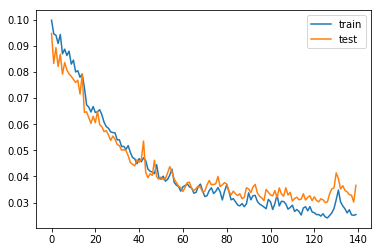

In [0]:
##### 03 Evaluation

# plot history
plt.plot(history.history['loss'][10:], label='train')
plt.plot(history.history['val_loss'][10:], label='test')
plt.legend()

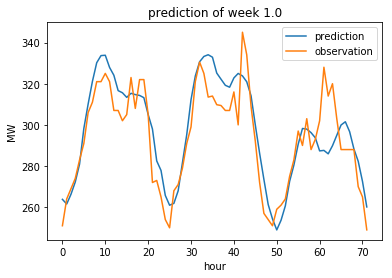

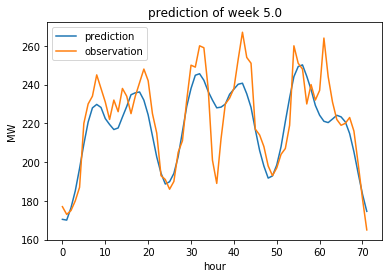

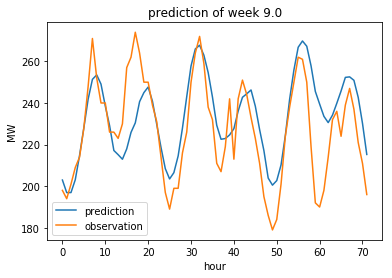

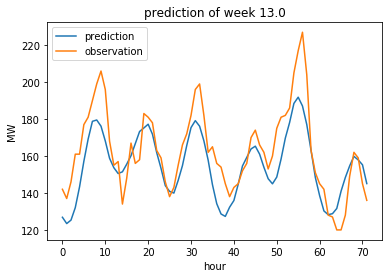

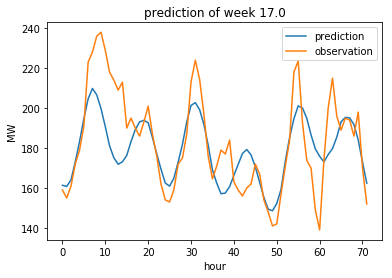

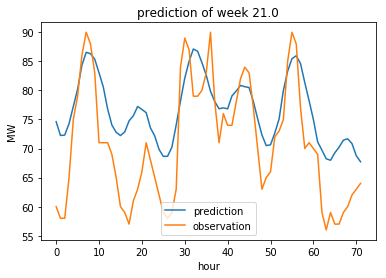

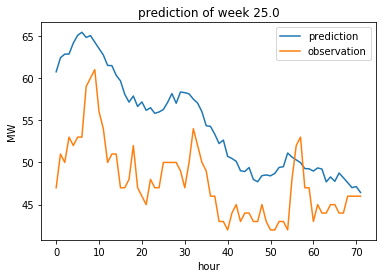

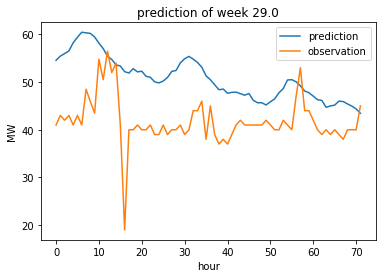

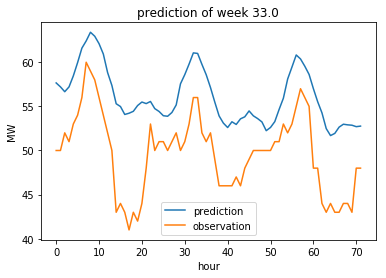

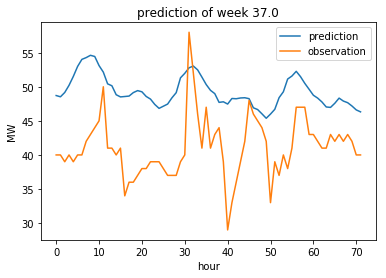

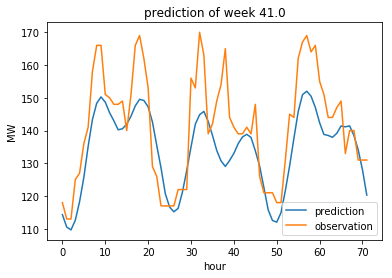

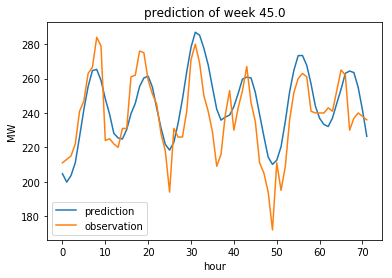

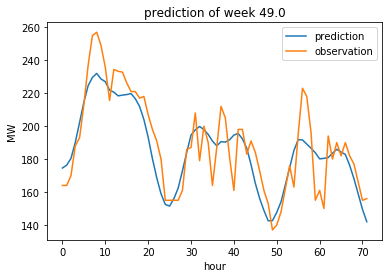

In [0]:
# plot prediction
 for i in range(0, len(y_test), 24*7*4):
     plt.figure(i)
     plt.plot(yhat[i], label='prediction')
     plt.plot(y_test[i], label ='observation')
     plt.title('prediction of week ' + str((round(i/(24*7)+1,0))))
     plt.xlabel('hour');plt.ylabel('MW');plt.legend()
     plt.legend()



In [0]:
# plot "fitted values"
 for i in range(0, len(y_train), 24*7*4):
     plt.figure(i+10)
     plt.plot(yfit[i], label='fitted values')
     plt.plot(y_train[i], label ='observation')
     plt.title('fitted values of week ' + str((round(i/(24*7)+1,0))))
     plt.xlabel('hour');plt.ylabel('MW');plt.legend()
     plt.legend()